In [19]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt

import sys 
sys.path.append('..')
from tools import utils, amputation
from alternative_imputers import muzellec_imputers
from tools.utils import colors
from tqdm import tqdm

plt.style.use(utils.plot_style)

from tools import imputation
from sklearn.datasets import load_boston, load_wine, fetch_california_housing, load_iris, load_diabetes, load_linnerud
from sklearn.preprocessing import StandardScaler, scale

In [20]:
def get_data(dataset_name): 
    scaler = StandardScaler()
    if dataset_name == 'boston':
        X_full, y_full = load_boston(return_X_y=True)
    elif dataset_name == 'california_housing':
        X_full, y_full = fetch_california_housing(return_X_y = True)
    elif dataset_name == 'wine':
        X_full, y_full = load_wine(return_X_y=True)
       
    elif dataset_name == 'iris':
        X_full, y_full = load_iris(return_X_y=True)
    elif dataset_name == 'diabetes':
        X_full, y_full = load_diabetes(return_X_y=True)
        
    if dataset_name == 'real':
        curdir = os.getcwd()
        os.chdir("..")
        X_full = np.genfromtxt(os.path.join('data', 'data_ivanovo.csv') , delimiter=';', skip_header=2)
        df = pd.DataFrame(X_full)
        df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
        X_full = np.array(df)
        X_full = scaler.fit_transform(X_full)
        os.chdir(curdir)
        return X_full.astype(np.float32), None
    else:
        X_full = scaler.fit_transform(X_full, y_full)
        return scale(X_full).astype(np.float32), scale(y_full).astype(np.float32)

## Exemplary imputation on open datasets

In [21]:
n_impute = 5
datasets = ['iris', 'diabetes', 'wine']
p_misses = [0.10, 0.40, 0.7]
modes = ['mae', 'bayesianRidge']
mechas = ['MCAR', 'MAR', 'MNAR']
imputer_names = ['mean', 'knn', 'mice', 'miceforest']# , 'linearRR', 'sinkhorn']

params_grid = np.array(np.meshgrid(n_impute, datasets, p_misses, mechas, imputer_names, modes)).T.reshape(-1,6)
params_grid = np.vstack((np.arange(params_grid.shape[0]), params_grid.T)).T

results = []
results_regress = []
for param in tqdm(params_grid): ## tqdm -- progress bar
    idx, n_impute, dataset_name, p_miss, mecha, imputer_name, mode = param    
    means = []
    means_2 = []
    std_2 = []
    imps = []
    for i in range(int(n_impute)):
        X_full, y_full = get_data(dataset_name)
        X_full, X_miss, mask, imp = imputation.impute(X_full, p_miss = float(p_miss), mecha = mecha, imputer_name = imputer_name)
        mean, std, imp = imputation.assess_impute(X_full, mask, imp, mode = 'mae', y_full = y_full)
        means.append(mean)
        mean, std, imp = imputation.assess_impute(X_full, mask, imp, mode = 'bayesianRidge', y_full = y_full)
        means_2.append(mean)
        std_2.append(std)
        imps.append(imp)
    # means = [mean.detach().numpy() for mean in means]
    results.append([idx, np.mean(means), np.std(means), np.mean(imps)])
    results_regress.append([idx, np.mean(means_2), np.mean(std_2), np.mean(imps)])

 25%|██▌       | 55/216 [01:42<04:59,  1.86s/it]


KeyboardInterrupt: 

IndexError: list index out of range

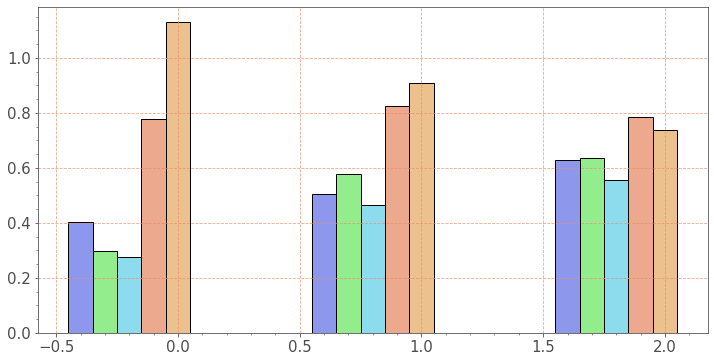

In [ ]:
# mode_f = 'bayesianRidge'#'mae'

for mode_f in modes:
    for mech_f in mechas:
        fig, ax = plt.subplots()
        for idx_miss, p_miss_f in enumerate(p_misses):

            # определяем переменные из params_grid (пр. строка)
            subgroup = lambda idx, imp_meth: (params_grid[idx][-3] == mech_f) and (float(params_grid[idx][-4]) == p_miss_f) and (params_grid[idx][-2] == imp_meth) and (params_grid[idx][-1] == mode_f)

            means = [res[1] for res in results]
            stds = [res[2] for res in results]
            labels = imputer_names

            means_s = []
            std_s = []
            imp_meth_s = []

            for imp_meth in imputer_names:
                means_s.append([mean for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])
                std_s.append([std for idx, std in enumerate(stds) if subgroup(idx, imp_meth)])
                imp_meth_s.append([params_grid[idx][-1] for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])

            x = np.arange(len(datasets))  # the label locations
            width = 0.1  # the width of the bars

            
            rects = []
            for idx, mean_i, std_i in zip(range(len(std_s)), means_s, std_s):
                rects.append(ax.bar(x - width * idx, mean_i, width, yerr = std_i, label=labels[idx], capsize=5, alpha=np.linspace(1, 0.2, len(p_misses))[idx_miss], color = colors[idx], edgecolor='black'))

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Scores')
            ax.set_title(f"{mech_f}, {(np.array(p_misses) * 100).astype(int)} %, mode: {mode_f}")
            ax.set_xticks(x)
            ax.set_ylim(0, 1.5)
            ax.set_xticklabels(datasets)
            ax.legend(imputer_names)
            ax.set_ylim(0)
            # for rect in rects:
            #     ax.bar_label(rect, padding=3)
        plt.savefig(f"figures/{mech_f}_{np.array(p_misses)*100} %, mode: {mode_f}_2.png", dpi=200)
fig.tight_layout()
plt.show()

## Imputation of the real data

In [55]:
n_impute = 1
datasets = ['real', 'diabetes']#, 'wine']
p_misses = [0.10, 0.40, 0.7]
modes = ['mae']#, 'bayesianRidge']
mechas = ['MAR']
imputer_names = ['mean', 'knn', 'mice', 'miceforest']# , 'linearRR', 'sinkhorn']

params_grid = np.array(np.meshgrid(n_impute, datasets, p_misses, mechas, imputer_names, modes)).T.reshape(-1,6)
params_grid = np.vstack((np.arange(params_grid.shape[0]), params_grid.T)).T

results_real = []
for param in tqdm(params_grid): ## tqdm -- progress bar
    idx, n_impute, dataset_name, p_miss, mecha, imputer_name, mode = param    
    means = []
    imps = []
    for i in range(int(n_impute)):
        X_full, y_full = get_data(dataset_name)
        X_full, X_miss, mask, imp = imputation.impute(X_full, p_miss = float(p_miss), mecha = mecha, imputer_name = imputer_name)
        mean, std, imp = imputation.assess_impute(X_full, mask, imp, mode = 'mae', y_full = y_full)
        means.append(mean)
        imps.append(imp)
    # means = [mean.detach().numpy() for mean in means]
    results_real.append([idx, np.mean(means), np.std(means), np.mean(imps)])

100%|██████████| 24/24 [18:19<00:00, 45.79s/it] 


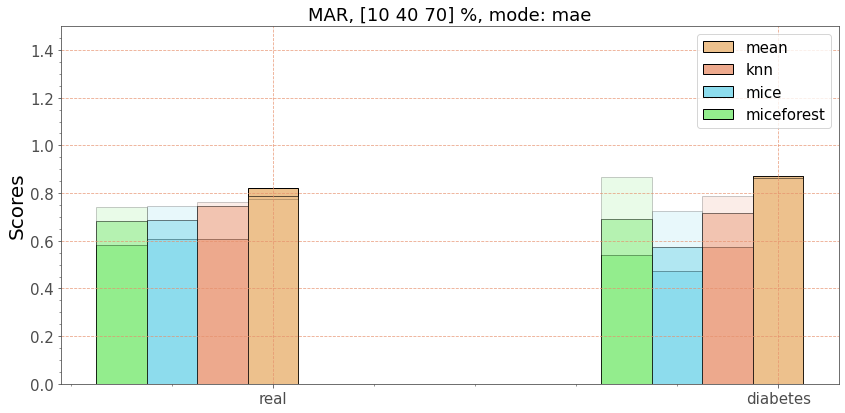

In [57]:
# mode_f = 'bayesianRidge'#'mae'

for mode_f in modes:
    for mech_f in mechas:
        fig, ax = plt.subplots()
        for idx_miss, p_miss_f in enumerate(p_misses):

            # определяем переменные из params_grid (пр. строка)
            subgroup = lambda idx, imp_meth: (params_grid[idx][-3] == mech_f) and (float(params_grid[idx][-4]) == p_miss_f) and (params_grid[idx][-2] == imp_meth) and (params_grid[idx][-1] == mode_f)

            means = [res[1] for res in results_real]
            stds = [res[2] for res in results_real]
            labels = imputer_names

            means_s = []
            std_s = []
            imp_meth_s = []

            for imp_meth in imputer_names:
                means_s.append([mean for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])
                std_s.append([std for idx, std in enumerate(stds) if subgroup(idx, imp_meth)])
                imp_meth_s.append([params_grid[idx][-1] for idx, mean in enumerate(means) if subgroup(idx, imp_meth)])

            x = np.arange(len(datasets))  # the label locations
            width = 0.1  # the width of the bars

            
            rects = []
            for idx, mean_i, std_i in zip(range(len(std_s)), means_s, std_s):
                rects.append(ax.bar(x - width * idx, mean_i, width, yerr = std_i, label=labels[idx], capsize=5, alpha=np.linspace(1, 0.2, len(p_misses))[idx_miss], color = colors[idx], edgecolor='black'))

            # Add some text for labels, title and custom x-axis tick labels, etc.
            ax.set_ylabel('Scores')
            ax.set_title(f"{mech_f}, {(np.array(p_misses) * 100).astype(int)} %, mode: {mode_f}")
            ax.set_xticks(x)
            ax.set_ylim(0, 1.5)
            ax.set_xticklabels(datasets)
            ax.legend(imputer_names)
            ax.set_ylim(0)
            # for rect in rects:
            #     ax.bar_label(rect, padding=3)
        plt.savefig(f"figures/{mech_f}_{np.array(p_misses)*100} %, mode: {mode_f}_real.png", dpi=200)
fig.tight_layout()
plt.show()

In [58]:
import miceforest as mf

In [60]:
X_full, y_full = get_data('real')

In [165]:
X_full, X_miss, mask, imp = imputation.impute(X_full, p_miss = float(0.4), mecha = 'MAR', imputer_name = 'mean')

In [166]:
# Create kernel. 
kds_gbdt = mf.ImputationKernel(
X_miss.detach().numpy(),
datasets=5,
mean_match_candidates=5,
save_all_iterations=True,
random_state=1991
)
# Using the first ImputationKernel in kernel to tune parameters
# with the default settings.
optimal_parameters, losses = kds_gbdt.tune_parameters(
dataset=0,
optimization_steps=5
)
# We need to add a small minimum hessian, or lightgbm will complain:
kds_gbdt.mice(iterations=5, boosting='gbdt', min_sum_hessian_in_leaf=0.01)
# Return the completed kernel data
imp = kds_gbdt.complete_data(dataset=0)

In [205]:
imp = kds_gbdt.complete_data(dataset=0)

In [206]:
imp = kds_gbdt.complete_data(dataset=1)

In [167]:
plot_style_upd = {  
    'xtick.labelsize': '20',
    'ytick.labelsize': '20',
    'axes.labelsize':'20',
    'font.size': '20',
    'figure.figsize': '20, 15',
    }
loc_style = utils.plot_style.copy()
loc_style.update(plot_style_upd)
plt.style.use(loc_style)

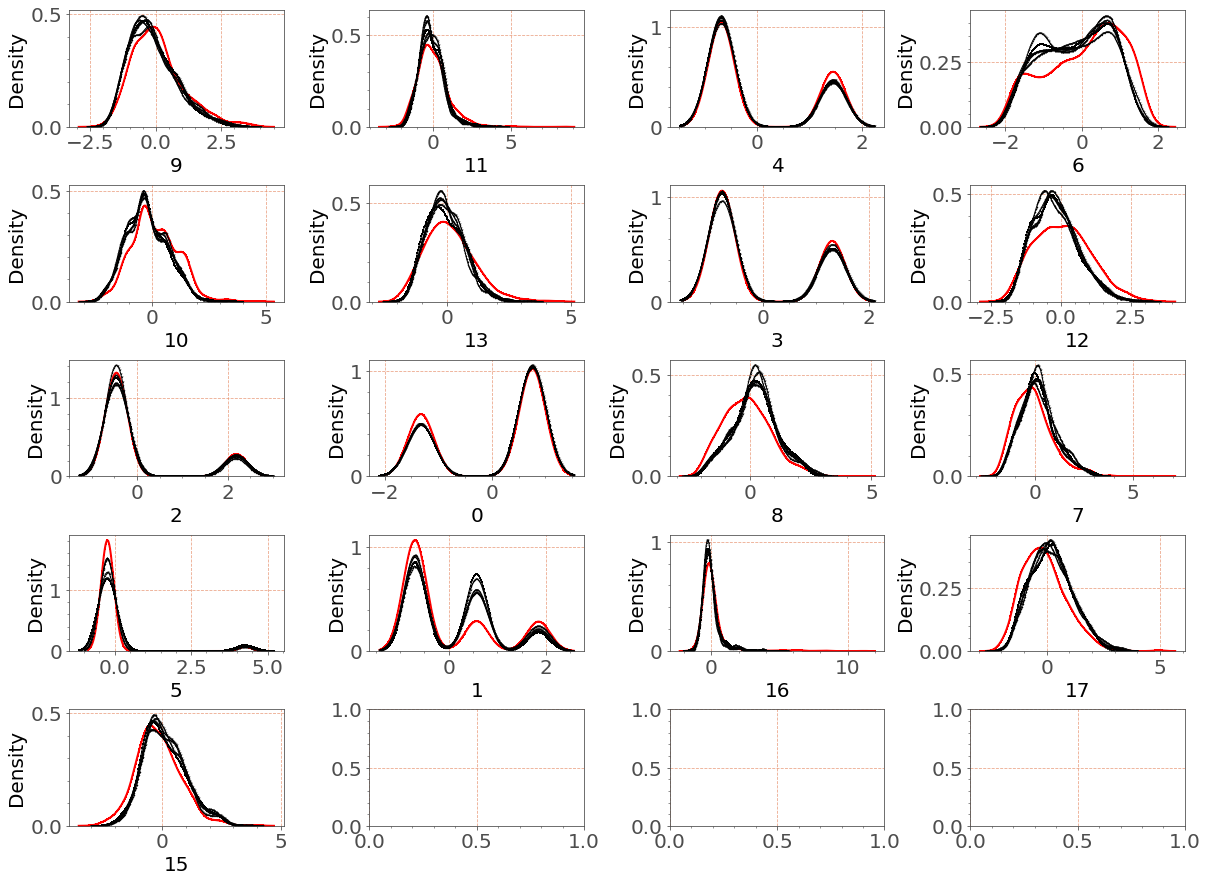

In [168]:


kds_gbdt.plot_imputed_distributions(wspace=0.4,hspace=0.5)
plt.savefig(f"figures/miceforest_MAR_40%_real.png", dpi=200)
# plt.tight_layout()

In [113]:
datasets

['real', 'diabetes']

In [120]:
var_indx = kds_gbdt._get_variable_index(None)
num_vars = kds_gbdt._get_num_vars(var_indx)

In [132]:
R1 = np.corrcoef(imp)

In [ ]:
R2 = np.corrcoef(xarr, yarr)

In [195]:
R3_full = np.corrcoef(X_full, rowvar=False)
R3_imp = np.corrcoef(imp, rowvar=False)

In [191]:
R3_full = np.corrcoef(X_full, rowvar=False)

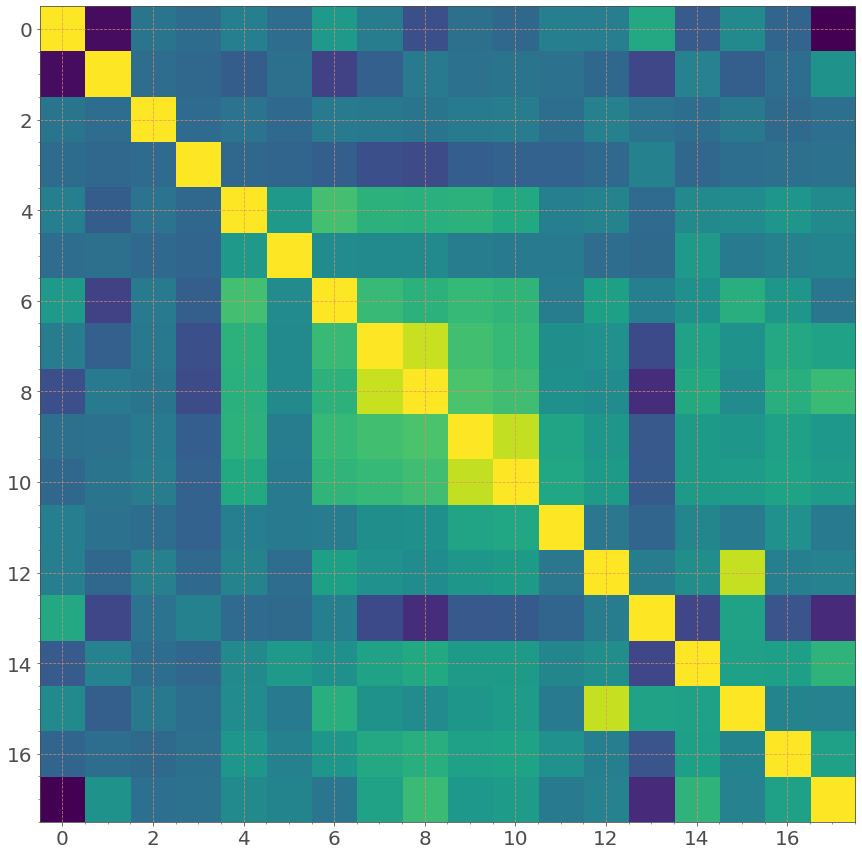

In [202]:
plt.imshow(R3_imp)

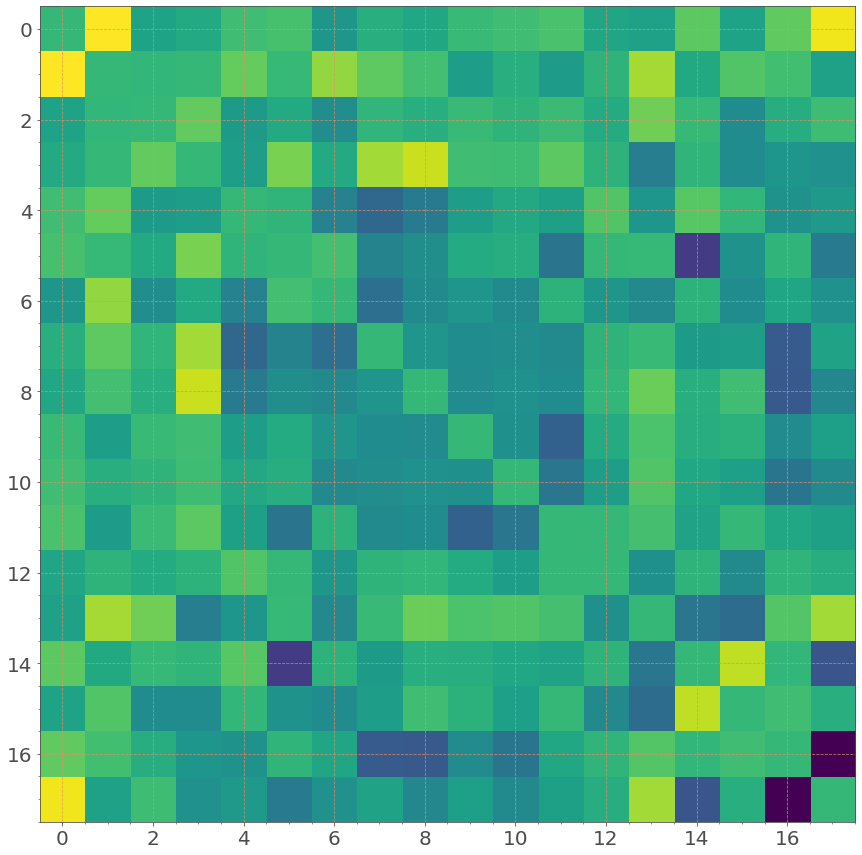

In [204]:
plt.imshow(R3_full - R3_imp)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe2ad06f0a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe2ad06f7c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe26dc9ca30>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe2ad06ff10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe2ad0822e0>,
 'means': []}

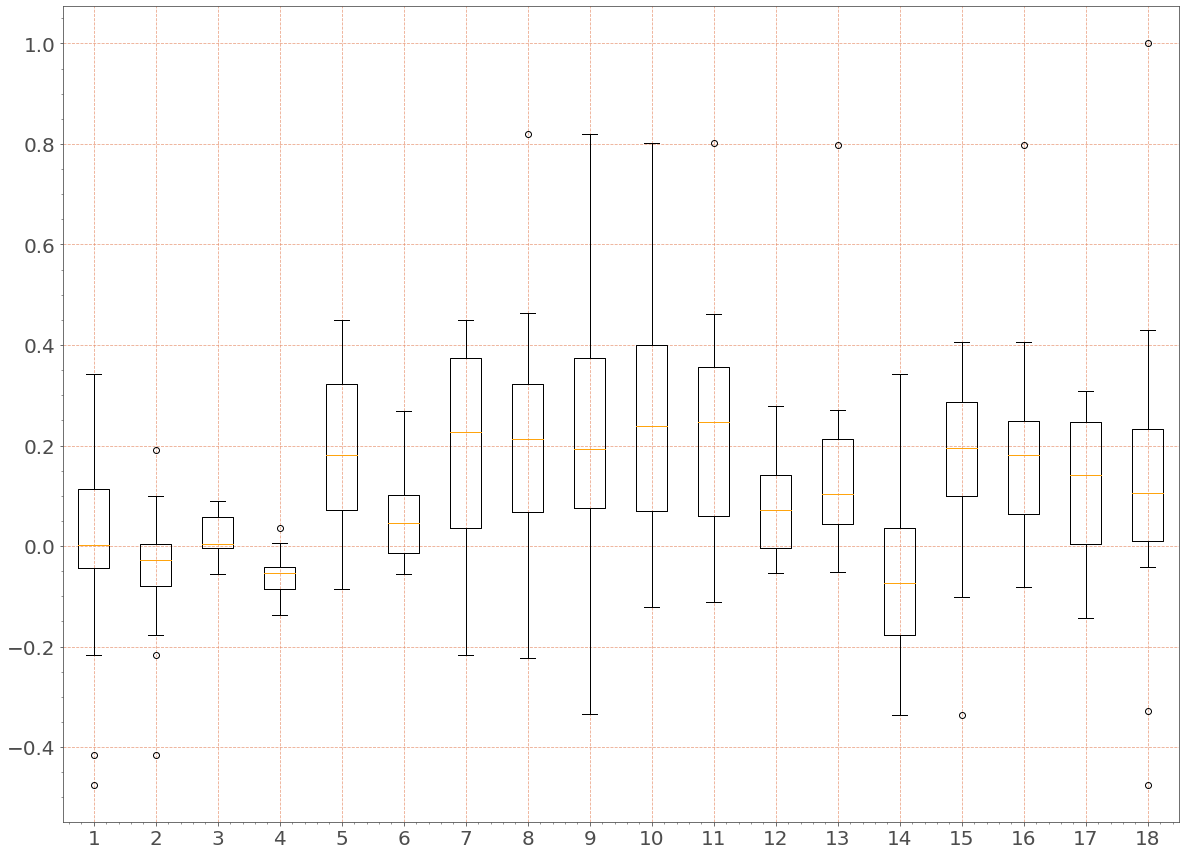

In [163]:
corrs = []
for R3_full_i in R3_full.T:
    corrs.append(R3_full_i[R3_full_i<1])
    

plt.boxplot(
                corrs
                # list(R3_full[:, 0]),
                # labels=range(len(correlation_dict[var])),
            )

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe26e850250>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe26e850970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe26e855e80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe26e8430d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe26e843460>,
 'means': []}

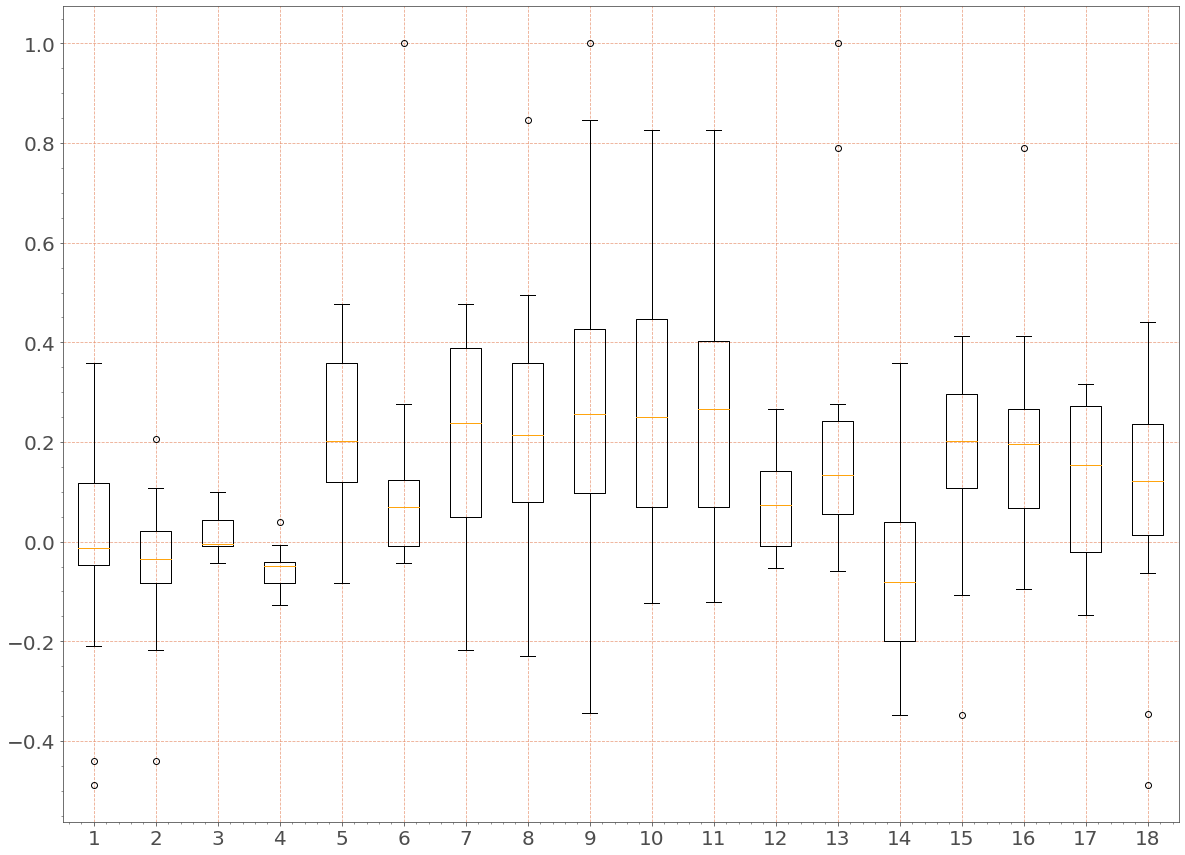

In [164]:
corrs = []
for R3_imp_i in R3_imp.T:
    corrs.append(R3_imp_i[R3_imp_i<1])
    

plt.boxplot(
                corrs
                # list(R3_full[:, 0]),
                # labels=range(len(correlation_dict[var])),
            )

In [129]:
correlation_dict = kds_gbdt.get_correlations(datasets=[0, 1], variables=num_vars)

In [130]:
correlation_dict

{6: {1: [0.67], 2: [0.788], 3: [0.722], 4: [0.775], 5: [0.826]},
 3: {1: [0.262], 2: [0.333], 3: [0.345], 4: [0.345], 5: [0.279]},
 2: {1: [0.291], 2: [0.217], 3: [0.369], 4: [0.15], 5: [0.446]},
 16: {1: [0.692], 2: [0.806], 3: [0.829], 4: [0.832], 5: [0.809]},
 0: {1: [0.786], 2: [0.785], 3: [0.843], 4: [0.834], 5: [0.776]},
 10: {1: [0.79], 2: [0.833], 3: [0.845], 4: [0.851], 5: [0.846]},
 9: {1: [0.831], 2: [0.863], 3: [0.849], 4: [0.84], 5: [0.883]},
 15: {1: [0.767], 2: [0.852], 3: [0.852], 4: [0.903], 5: [0.93]},
 8: {1: [0.897], 2: [0.927], 3: [0.938], 4: [0.944], 5: [0.959]},
 13: {1: [0.813], 2: [0.825], 3: [0.811], 4: [0.862], 5: [0.836]},
 14: {1: [0.76], 2: [0.858], 3: [0.811], 4: [0.814], 5: [0.799]},
 17: {1: [0.75], 2: [0.787], 3: [0.778], 4: [0.804], 5: [0.765]},
 5: {1: [0.12], 2: [0.353], 3: [0.206], 4: [0.393], 5: [0.312]},
 1: {1: [0.581], 2: [0.603], 3: [0.603], 4: [0.605], 5: [0.622]},
 7: {1: [0.864], 2: [0.895], 3: [0.889], 4: [0.922], 5: [0.925]},
 12: {1: [0.

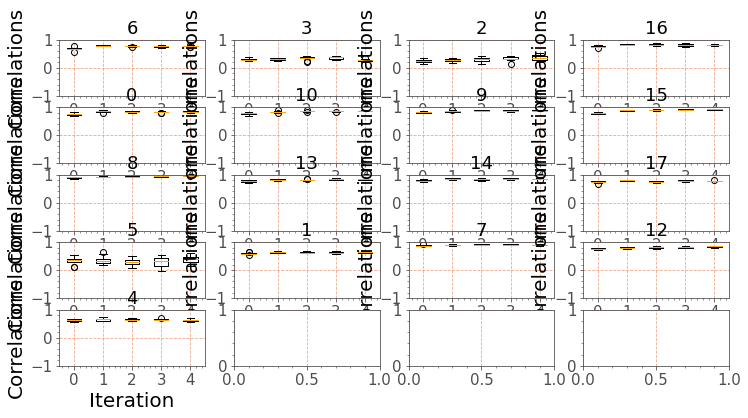

In [78]:
kds_gbdt.plot_correlations()

AxesSubplot(0.125,0.125;0.62x0.755)


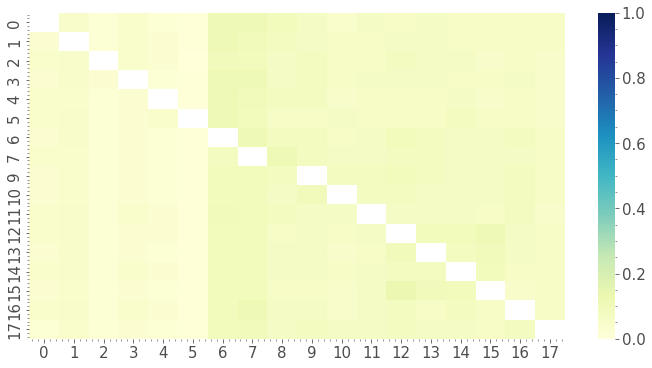

In [73]:
kds_gbdt.plot_feature_importance(dataset=1, annot=False,cmap="YlGnBu",vmin=0, vmax=1)

## Pooling

In [203]:
def variance_model_coef(y_true, y_pred, X):
    """Calculates variance of the coefficients."""
    residual_sum_squares = np.sum((y_true - y_pred) ** 2)
    residual_mean_square = residual_sum_squares / (len(y_true) - 2)
    return residual_mean_square / (X ** 2).sum(axis=0)


def rubins_pooling_rules(m_coefs, m_vars_coefs):
    """Applies Rubin's pooling rules.
    The final weights is defined as the mean of the weights across the imputed
    datasets while the total variance is defined as the combination of the mean
    of the variance of the weights and the variance of the coefficients.
    Parameters
    ----------
    m_coefs : ndarray, shape (n_imputations, n_features)
        The weights of the model fitted on each imputed dataset.
    m_vars_coefs : ndarray, shape (n_imputations, n_features)
        An estimate of the variance of the weights on each imputed dataset.
    Returns
    -------
    mean_coefs : ndarray, shape (n_features,)
        The mean coefficients computed across the imputed datasets.
    total_var_coefs : ndarray, shape (n_features,)
        An estimate of the total variation of the weights across the imputed
        datasets.
    """
    mean_coefs = np.mean(m_coefs, axis=0)
    mean_vars_coefs = np.mean(m_vars_coefs, axis=0)
    vars_coefs = np.var(m_coefs, axis=0, ddof=1)
    total_var_coefs = mean_vars_coefs + (1 + 1 / vars_coefs.shape[0]) * vars_coefs
    return mean_coefs, total_var_coefs



def get_results_chained_imputation(X_ampute, y, random_state=0, impute_with_y=False):
    # Impute incomplete data with IterativeImputer using single imputation
    # We perform MAX_ITER imputations and only use the last imputation.
    imputer = IterativeImputer(
        max_iter=MAX_ITER, sample_posterior=True, random_state=random_state
    )
    if impute_with_y:
        Xy = np.column_stack((X_ampute, y))
        # impute Xy, but exclude last column for subsequent regression
        X_imputed = imputer.fit_transform(Xy)[:, :-1]
    else:
        X_imputed = imputer.fit_transform(X_ampute)

    # Perform linear regression on chained single imputed data
    # Estimate beta estimates and their variances
    y_predict = ESTIMATOR.fit(X_imputed, y).predict(X_imputed)

    # Save the beta estimates, the variance of these estimates
    return (
        ESTIMATOR.named_steps["regressor"].coef_,
        variance_model_coef(y, y_predict, X_imputed),
    )


def coef_var_mice_imputation(X_ampute, y, n_imputations=5, impute_with_y=False):
    # Train a model on each of the `m` imputed datasets
    # Estimate the estimates for each model/dataset
    m_coefs = []
    m_vars = []
    for i in range(n_imputations):
        m_coef, m_var = get_results_chained_imputation(
            X_ampute, y, random_state=i, impute_with_y=impute_with_y
        )
        m_coefs.append(m_coef)
        m_vars.append(m_var)

    m_coefs = np.array(m_coefs)
    m_vars = np.array(m_vars)
    # Calculate the end estimates by applying Rubin's rules.
    return rubins_pooling_rules(m_coefs, m_vars)

In [ ]:
X_ampute = ampute(X, strategy="MCAR")

# Second, run all the imputation procedures as described above.
full_coefs, full_vars = get_results_full_dataset(X, y)
chained_coefs, chained_vars = get_results_chained_imputation(X_ampute, y)
mice_coefs, mice_vars = coef_var_mice_imputation(X_ampute, y)
mice_y_coefs, mice_y_vars = coef_var_mice_imputation(X_ampute, y, impute_with_y=True)

# Combine the results from the four imputation procedures.
coefs = [full_coefs, chained_coefs, mice_coefs, mice_y_coefs]
standard_errors = [
    1.96 * np.sqrt(v) for v in (full_vars, chained_vars, mice_vars, mice_y_vars)
]

In [207]:
imp = kds_gbdt.complete_data(dataset=0)

In [208]:
def variance_model_coef(y_true, y_pred, X):
    """Calculates variance of the coefficients."""
    residual_sum_squares = np.sum((y_true - y_pred) ** 2)
    residual_mean_square = residual_sum_squares / (len(y_true) - 2)
    return residual_mean_square / (X ** 2).sum(axis=0)

In [209]:
from sklearn.linear_model import BayesianRidge

In [252]:
m_coefs=[]
m_vars=[]
for imp_idx in range(5):
    imp = kds_gbdt.complete_data(dataset=imp_idx)
    y_test_idx = X_full[:,imp_idx]
    X_full_2 = X_full.copy()
    X_full_2 = np.delete(X_full_2.T, imp_idx).T

    bayes_regr = BayesianRidge().fit(imp, y_test_idx)
    y_predict_idx = bayes_regr.predict(imp)
    m_var = variance_model_coef(y_test_idx, y_predict_idx, X_full_2)
    m_coefs.append(bayes_regr.coef_)
    m_vars.append(m_var)
m_coefs = np.array(m_coefs)
m_vars = np.array(m_vars)

In [253]:
rub_rules = rubins_pooling_rules(m_coefs, m_vars)

In [254]:
rub_rules[0]

array([ 0.15306262,  0.15030484,  0.11872695,  0.12187042,  0.1246974 ,
        0.00244093,  0.01362252, -0.00293741, -0.01713413,  0.01641346,
        0.01545416, -0.01784154,  0.02865877,  0.00662331,  0.00077968,
       -0.03627112,  0.00760896, -0.00609808])

Text(0, 0.5, 'Bayesian regression coeff')

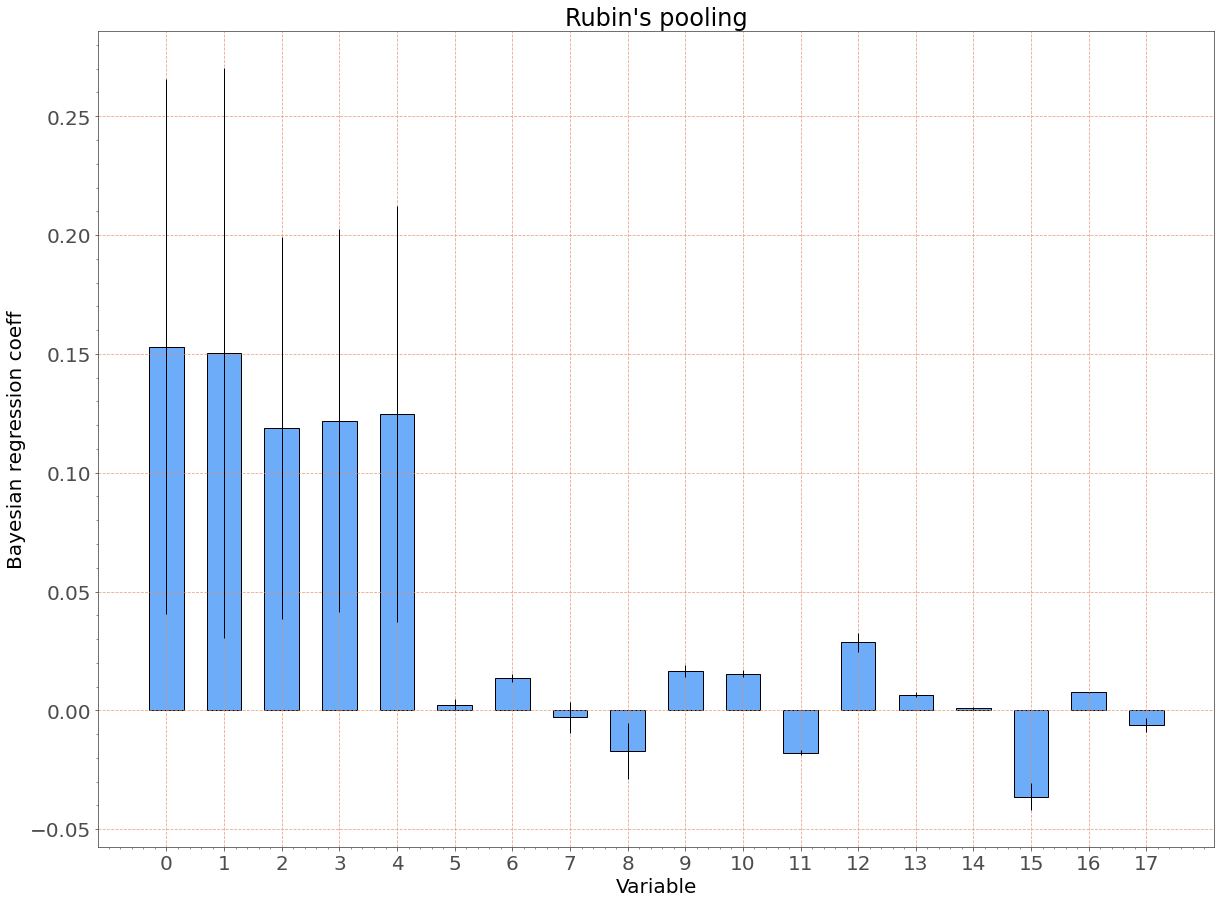

In [255]:
plt.bar(np.arange(len(rub_rules[0])), rub_rules[0], width=0.6, yerr = rub_rules[1], label=np.arange(len(rub_rules[0])).astype(str),capsize=5, edgecolor='black', color='#6DACF9')
plt.xticks(np.arange(len(rub_rules[0])).astype(int))
plt.title("Rubin's pooling")
plt.xlabel("Variable")
plt.ylabel("Bayesian regression coeff")


In [230]:
x = np.arange(len(rub_rules))  # the label locations
width = 0.1  # the width of the bars


rects = []
for idx in range(len(x)):
    rects.append(ax.bar(x - width * idx, rub_rules[0], width, yerr = rub_rules[1], capsize=5, edgecolor='black'))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title(f"{mech_f}, {(np.array(p_misses) * 100).astype(int)} %, mode: {mode_f}")
ax.set_xticks(x)
ax.set_ylim(0, 1.5)
ax.set_xticklabels(datasets)
ax.legend(imputer_names)
ax.set_ylim(0)

ValueError: shape mismatch: objects cannot be broadcast to a single shape